In [1]:
import cv2
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt

### Initial Panorama to Perspective Conversion
We began by converting an equirectangular (360-degree panoramic) image to a perspective view. The perspective projection is determined by calculating the yaw and pitch from the camera's position to a target point. The formula uses GPS coordinates, along with field-of-view (FOV) and roll angle adjustments, to create a 2D view that simulates a camera looking at a specific point.

In [2]:
def calculate_yaw_pitch(camera_coords, target_coords):
    """
    Calculate yaw (theta) and pitch (phi) angles between the camera position and target point.

    Parameters:
    - camera_coords: (x, y, z) coordinates of the camera position.
    - target_coords: (x, y, z) coordinates of the target point.

    Returns:
    - yaw (theta) in degrees, pitch (phi) in degrees.
    """
    # Unpack the coordinates
    x1, y1, z1 = camera_coords
    x2, y2, z2 = target_coords

    # Calculate differences in x, y, z
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    
    # Calculate the yaw (theta): horizontal direction
    theta = math.atan2(dy, dx)  # Azimuth
    theta_deg = math.degrees(theta)
    
    # Calculate the pitch (phi): vertical direction
    horizontal_distance = math.sqrt(dx**2 + dy**2)
    phi = math.atan2(dz, horizontal_distance)  # Elevation angle
    phi_deg = math.degrees(phi)
    
    return theta_deg, phi_deg

def equirectangular_to_perspective_from_image(img, fov, theta, phi, roll, height, width):
    """
    Convert an equirectangular (360-degree) image to a perspective projection using an already loaded image.
    
    Parameters:
    - img: The equirectangular image already loaded (preprocessed if needed).
    - fov: Field of view of the output image (in degrees).
    - theta: Yaw angle (azimuth) in degrees.
    - phi: Pitch angle in degrees.
    - roll: Roll angle in degrees.
    - height: Output image height.
    - width: Output image width.

    Returns:
    - Perspective projection of the given equirectangular image.
    """
    # Convert angles to radians
    fov = math.radians(fov)
    theta = math.radians(theta)
    phi = math.radians(phi)
    roll = math.radians(roll)
    
    # Prepare perspective output image
    out_img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Get dimensions of the equirectangular image
    h, w, _ = img.shape
    
    # Calculate the focal length based on the FOV and image width
    f = width / (2 * math.tan(fov / 2))
    
    # Create rotation matrices based on yaw, pitch, and roll
    Rx = np.array([[1, 0, 0], [0, math.cos(phi), -math.sin(phi)], [0, math.sin(phi), math.cos(phi)]])  # Pitch
    Ry = np.array([[math.cos(theta), 0, math.sin(theta)], [0, 1, 0], [-math.sin(theta), 0, math.cos(theta)]])  # Yaw
    Rz = np.array([[math.cos(roll), -math.sin(roll), 0], [math.sin(roll), math.cos(roll), 0], [0, 0, 1]])  # Roll
    
    R = Rz @ Ry @ Rx  # Combined rotation matrix
    
    # Loop over each pixel in the perspective image
    for i in range(height):
        for j in range(width):
            # Convert pixel coordinates to angles in the perspective image
            x = (j - width / 2) / f
            y = (i - height / 2) / f
            
            # Calculate direction vector for this pixel
            direction = np.array([x, y, 1])
            direction = direction / np.linalg.norm(direction)  # Normalize the vector
            
            # Apply rotation to the direction vector
            direction = R @ direction
            
            # Calculate spherical coordinates (theta, phi) for the pixel
            theta_p = math.atan2(direction[0], direction[2])
            phi_p = math.asin(direction[1])
            
            # Convert back to equirectangular coordinates
            u = (theta_p / (2 * math.pi) + 0.5) * w
            v = (phi_p / math.pi + 0.5) * h
            
            # Ensure the coordinates are within bounds and use interpolation
            u = np.clip(u, 0, w - 1)
            v = np.clip(v, 0, h - 1)
            
            # Bilinear interpolation for better quality
            u_floor = int(np.floor(u))
            v_floor = int(np.floor(v))
            u_ceil = min(u_floor + 1, w - 1)
            v_ceil = min(v_floor + 1, h - 1)
            
            # Interpolation weights
            wu = u - u_floor
            wv = v - v_floor
            
            # Interpolate between four surrounding pixels
            top_left = img[v_floor, u_floor]
            top_right = img[v_floor, u_ceil]
            bottom_left = img[v_ceil, u_floor]
            bottom_right = img[v_ceil, u_ceil]
            
            top = (1 - wu) * top_left + wu * top_right
            bottom = (1 - wu) * bottom_left + wu * bottom_right
            pixel_value = (1 - wv) * top + wv * bottom
            
            # Assign the pixel value
            out_img[i, j] = pixel_value.astype(np.uint8)
    
    return out_img

In [3]:
# Parameters for perspective projection
gdf = gpd.read_file('data/DEMO_TRACCIATO/RUN.shp')

selection = 10

image_name = gdf.loc[selection,'FOTO']
fov = 90  # Field of view
theta = gdf.loc[selection,'Heading']  # Yaw (from the Heading column in your data)
phi = gdf.loc[selection,'Pitch']  # Pitch (from the Pitch column in your data)
roll = gdf.loc[selection,'Roll']  # Roll can be applied if needed
output_width = 640
output_height = 480

(4000, 8000, 3)


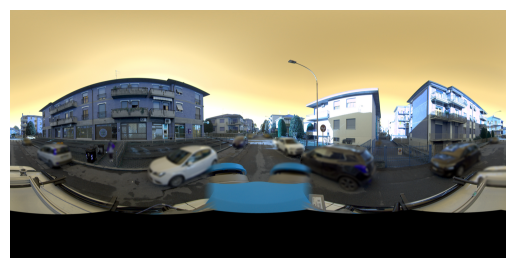

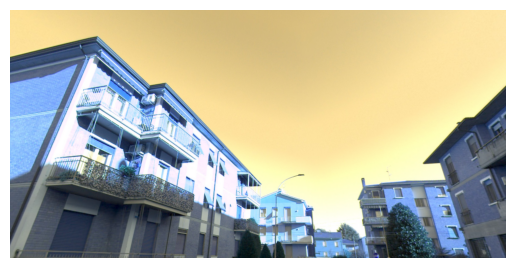

In [4]:
# Example coordinates for camera and target (replace with your actual coordinates)
camera_coords = (gdf.loc[selection,'X'], gdf.loc[selection,'Y'], gdf.loc[selection,'Z'])  # Camera position (x, y, z)
target_coords = (gdf.loc[selection,'X'] - 20, gdf.loc[selection,'Y'] + 5, gdf.loc[selection,'Z'] + 10)  # Target position (x, y, z)

# Calculate the yaw and pitch based on the coordinates
yaw, pitch = calculate_yaw_pitch(camera_coords, target_coords)

# Path to the image
images_folder = 'data/PANO_21_17/'
image_path = images_folder + image_name
image = cv2.imread(image_path)

print(image.shape) # the panorama image is 4000x8000, so aspect ration is 2:1

# Parameters for perspective projection
fov = 90  # Field of view
roll = gdf.loc[selection,'Roll'] 

output_image_shape = 'rectangular' # 'squared' or 'rectangular'
if output_image_shape == 'squared':
    output_width = 1024
    output_height = 1024
elif output_image_shape == 'rectangular':
    output_width = 1024
    output_height = 512

# Apply the transformation
output_image = equirectangular_to_perspective_from_image(image, fov, yaw, pitch, roll, output_height, output_width)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

# Display the images
plt.imshow(output_image)
plt.axis('off')  # Hide the axes
plt.show()


### Identifying the Color Issue (BGR vs. RGB)
OpenCV loads images in BGR format by default, but matplotlib and other libraries often expect images in RGB format. This mismatch causes the colors to appear incorrectly when displayed.

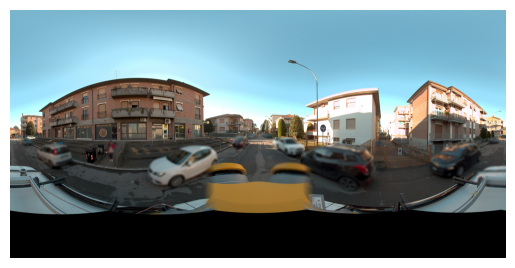

In [5]:
def convert_bgr_to_rgb(image):
    # Converts the image from OpenCV's BGR format to RGB for correct color representation
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the original image to RGB before any further processing
rgb_image = convert_bgr_to_rgb(image)

# Display using matplotlib
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

### Enhancing the Image: Histogram Equalization
Once the color space issue was resolved, we applied histogram equalization to enhance the image's contrast and brightness. This technique redistributes pixel intensities across the image to improve contrast, especially in scenes with varying lighting conditions.

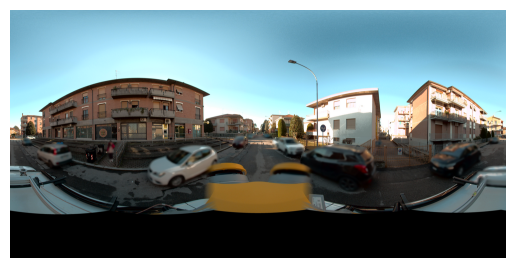

In [6]:
def equalize_histogram(image):
    # Convert to YUV color space and equalize the Y (luminance) channel
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    
    # Convert back to RGB color space
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

# Apply histogram equalization
equalized_image = equalize_histogram(rgb_image)

# Display the adjusted image
plt.imshow(equalized_image)
plt.axis('off')
plt.show()


### Applying the Equalized Image to Perspective Transformation
With the histogram equalization applied, we re-ran the perspective conversion to obtain the final enhanced view of the scene. This step ensured that the enhanced image was transformed into the perspective view while preserving the visual improvements.

In [7]:
# Perform perspective transformation on the origianl and histogram-equalized image
original_perspective = equirectangular_to_perspective_from_image(rgb_image, fov, yaw, pitch, roll, output_height, output_width)
equalized_perspective = equirectangular_to_perspective_from_image(equalized_image, fov, yaw, pitch, roll, output_height, output_width)

### Comparing the Results: Original vs. Equalized
Finally, we compared the original image (with RGB correction) and the histogram-equalized image to observe the visual improvements in contrast, brightness, and overall quality.

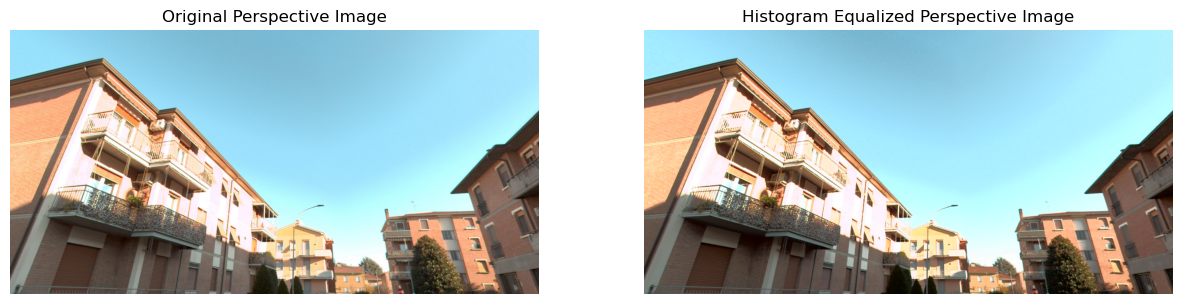

In [8]:
# Visual comparison of the original and equalized perspective images
plt.figure(figsize=(15, 5))

# Original Perspective Image
plt.subplot(1, 2, 1)
plt.imshow(original_perspective)
plt.title("Original Perspective Image")
plt.axis('off')

# Equalized Perspective Image
plt.subplot(1, 2, 2)
plt.imshow(equalized_perspective)
plt.title("Histogram Equalized Perspective Image")
plt.axis('off')

plt.show()
